<a href="https://colab.research.google.com/github/davidtweedle/elliptic-curve-data-science/blob/main/scale_invariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Murmurations for elliptic curves ordered by naive height
-----------------------------------------------------------------------------------------------------------------------------
Let's rescale the x-coordinates as $p/N(E)$ instead of $p$, where $N(E)$ is the conductor of $E$.
To motivate the rescaling, let's look at the elliptic curves with height $\leq 64$ with no rescaling.
We have computed data for elliptic curves $E_{A,B}:y^2 = x^3+Ax+B$ with $A,B$ both in the range $-64,-63,\ldots,0,1,2,\ldots,64$.
We have computed the $a_p(E)$ for these curves for $p\leq 100000$.

In [1]:
import os
using_colab = 'COLAB_GPU' in os.environ

In [2]:
if using_colab:
  ! pip install -q ipympl
  from google.colab import output
  output.enable_custom_widget_manager()

In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
%matplotlib widget

In [4]:
if using_colab:
  def bin_murmuration(ec:pd.DataFrame, primes:pd.Index, x):
    n = len(x)
    idx = np.digitize(np.outer(np.reciprocal(1.0*ec['conductor']),primes.astype(float)),x)
    counts = np.zeros(shape=x.shape)
    sum_aps = np.zeros(shape=x.shape)
    for i in range(n):
      where = np.equal(idx,i)
      counts[i] = where.sum()
      sum_aps[i] = ec[primes].to_numpy()[where].sum()
    return sum_aps,counts

  def display_murmuration(ec,scale,primes,title,ax,xlim=None,ylim=None):
    for axis in ax:
      axis.clear();
      if xlim:
        axis.set_xlim(*xlim)
      if ylim:
        axis.set_ylim(*ylim)
    t = primes.astype(int)*scale;
    ax[0].plot(t,ec.loc[ec['rank']==1,primes].mean(),'b.');
    ax[1].plot(t,ec.loc[ec['rank']==-1,primes].mean(),'r.');
    ax[2].plot(t,ec[primes].mul(ec['rank'],axis=0).mean(),'c.');
    ax[0].set_title(title+", even rank");
    ax[1].set_title(title+", odd rank");
    ax[2].set_title(title+", combined ranks");

  def display_rescaled_murmuration(x,sum_aps_even,counts_even,sum_aps_odd,counts_odd,title,ax,xlim=None,ylim=None):
    for axis in ax:
      axis.clear();
      if xlim:
        axis.set_xlim(*xlim)
      if ylim:
        axis.set_ylim(*ylim)
    ax[0].plot(x,sum_aps_even/counts_even,'b.');
    ax[1].plot(x,sum_aps_odd/counts_odd,'r.');
    ax[2].plot(x,(sum_aps_even-sum_aps_odd)/(counts_even+counts_odd),'c.');
    ax[0].set_title(title+", even");
    ax[1].set_title(title+", odd");
    ax[2].set_title(title+", combined ranks");
else:
  from pyscript.murmur_from_dataframe import display_murmuration, bin_murmuration, display_rescaled_murmuration

In [5]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
from googleapiclient.http import MediaIoBaseDownload

fileIds = {"first_example.data": "1-x2JSb8S5y3yQflZ238XIRFYdxwmzLAz",
           "second_example.data": "101A9ow90-kZPQK5gpxggZcr1FdPT-Nav"
}

def load_file(fileId, index_col,using_colab=True):
  file_link = None
  if using_colab:
    request = drive_service.files().get_media(fileId=fileId)
    file_link = io.BytesIO()
    downloader = MediaIoBaseDownload(file_link, request)
    done = False
    while done is False:
      _, done = downloader.next_chunk()
    file_link.seek(0)
  else:
    file_link="data/" + fileId
  datatype = {'label': np.dtype('str'),'discriminant':np.dtype('O')}
  datatype.setdefault(np.dtype('int64'))
  res = pd.read_csv(file_link,
                    delimiter=" ",
                    index_col=index_col,
                    usecols=lambda x: x!='discriminant',
                    dtype=datatype
  )
  if using_colab:
    file_link.close()
  return res

In [6]:
ec_height= load_file(fileId=fileIds["second_example.data"], using_colab=using_colab, index_col="A,B")
ec_height.head()

,conductor,rank,2,3,5,7,11,13,17,19,...,99877,99881,99901,99907,99923,99929,99961,99971,99989,99991
"A,B",,,,,,,,,,,,,,,,,,,,,
"-64,-64",3664,0,0,3,-3,4,3,-4,-7,5,...,531,-393,-451,518,-506,50,-18,108,-220,43
"-63,-64",4744512,1,0,0,-1,4,-1,6,2,7,...,157,61,183,220,92,86,-392,323,276,426
"-62,-64",6741760,1,0,0,1,-3,6,-4,3,2,...,-12,-82,412,436,168,-208,-492,-270,191,55
"-61,-64",6378656,0,0,3,-2,-3,2,-5,5,7,...,-134,-15,-550,372,332,94,107,122,228,-314
"-60,-64",94176,0,0,0,0,4,-2,6,-3,1,...,50,117,274,-422,-14,42,48,-180,586,70


In [7]:
primes = ec_height.columns[2:]

First, let's display the plots for the average $a_p(E)$ for all elliptic curves $E:y^2= x^3+Ax+B$ with $A,B$ ranging from $-64$ to $64$.
To give context to the previous notebook, this is what we should reasonably expect from doing these calculations (in other words, we would have expected to have no discernable pattern except that the means should be roughly around 0).

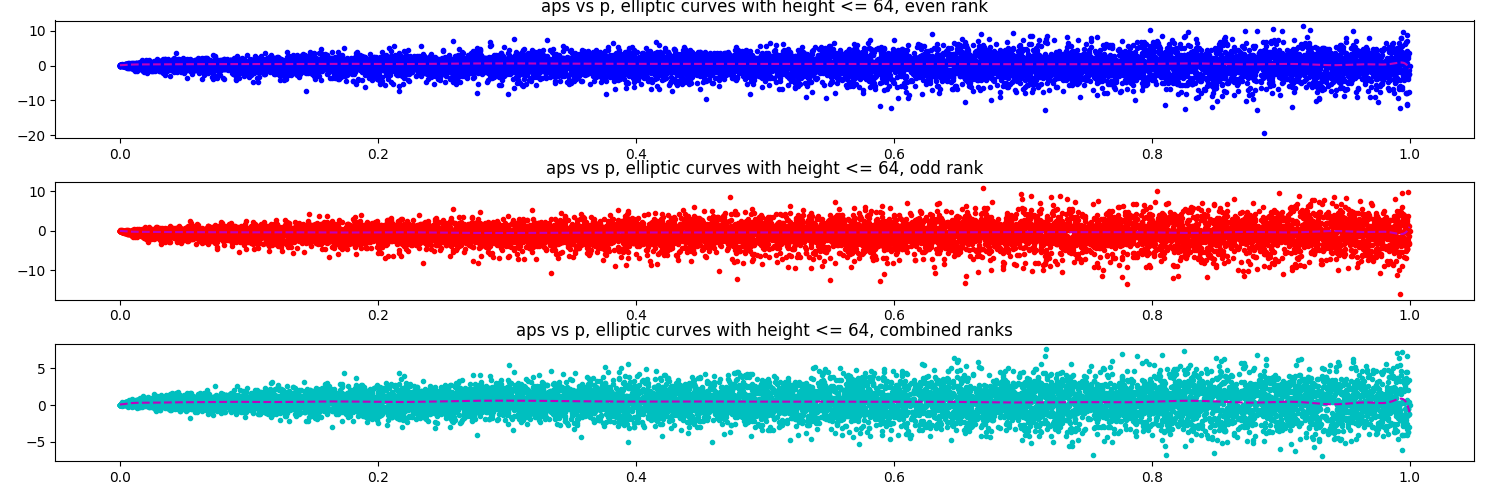

In [8]:
from numpy.polynomial import Polynomial as P
fig, ax = subplots(3,figsize=(15,5));
fig.tight_layout()
ec_height.loc[ec_height['rank']%2==1,'rank'] = -1;
ec_height.loc[ec_height['rank']%2==0,'rank'] = 1;
scale = 1.0/100000;
t = primes.astype(int)*scale
display_murmuration(ec_height,scale,primes,"aps vs p, elliptic curves with height <= 64", ax)
polyfit = P.fit(t,ec_height[primes].mul(ec_height['rank'],axis=0).mean(),30)
ax[0].plot(t, polyfit(t),'m--');
ax[1].plot(t,-polyfit(t),'m--');
ax[2].plot(t,polyfit(t),'m--')

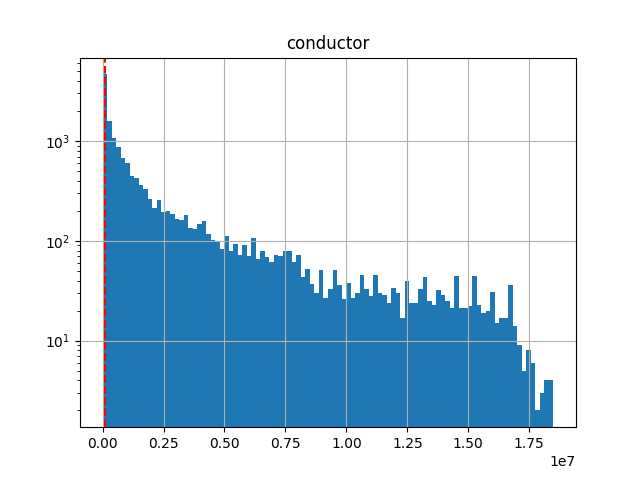

In [9]:
_,ax = subplots()
ec_height.hist(column='conductor',log=True,ax=ax,bins=100)
ax.axvline(int(primes[-1]),color='red',ls='--')

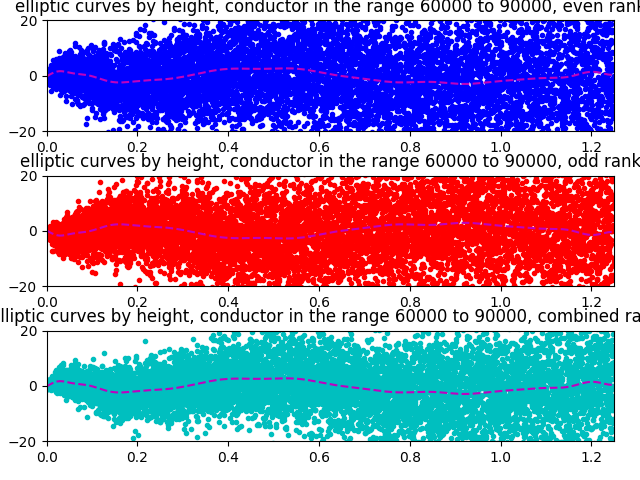

In [10]:
scale = 1.0/75000;
t = primes.astype(int)*scale
fig2, ax2 = subplots(3)
fig2.tight_layout();
xlim = (0,1.25)
ylim = (-20,20)
polyfit = P.fit(t,ec_height.loc[ec_height['conductor']<90000].loc[ec_height['conductor']>60000][primes].mul(ec_height['rank'],axis=0).mean(),30);
display_murmuration(ec_height.loc[ec_height['conductor']<90000].loc[ec_height['conductor']>60000],
                    scale,primes,"elliptic curves by height, conductor in the range 60000 to 90000",ax2,
                   xlim,ylim);
ax2[0].plot(t,polyfit(t),'m--');
ax2[1].plot(t,-polyfit(t),'m--');
ax2[2].plot(t,polyfit(t),'m--');
# fig2.savefig("media/naive_height_64_cond_60k_90k_no_rescale.png");

This is an improvement over considering all curves with $A$ and $B$ in the range $-64$ to $64$.
We see there are some slight fluctuations in the average aps, but it is not as striking as when we considered all curves with conductor in the range $7500$ to $10000$.

We will consider all curves with height at most 64, we will bin each row according to the value of $p/N(E)$ where $N(E)$ is the conductor of $E$.
Hopefully this accentuates the murmuration phenomenon.
The binning is accomplished by the python script "bin_murmuration".
Each $a_p(E)$ is given a bin according to the value of $p/N(E)$.
Therefore, we compute the matrix $N(E)\cdot\mathrm{primes}$, i.e. an outer product of a column vector of the conductors of the elliptic curves, and a row vector consisting of the values of the primes. Then these are binned into $n$ intervals of length $N/n$. Then we separate the $a_p$ data into even rank and odd rank and compute the average over each bin for the data. We use the function "np.digitize" to try to accomplish the binning as fast as we can.

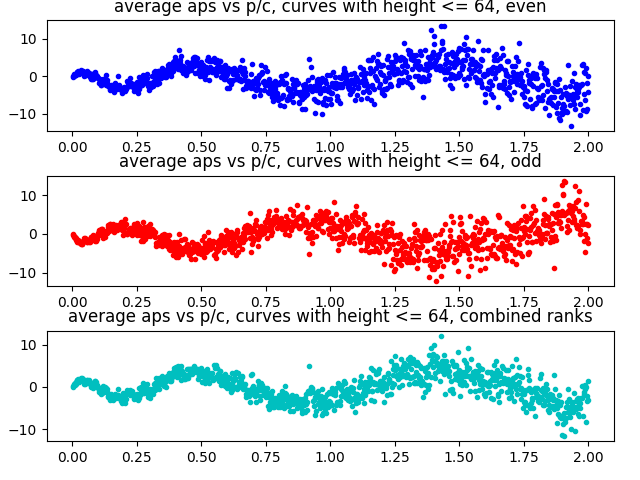

In [11]:
fig4, ax4 = subplots(3);
fig4.tight_layout();
N,n = 2,1000;
ec_height_odd = ec_height[ec_height['rank']==-1]
ec_height_even = ec_height[ec_height['rank']==1]
x = np.linspace(1.0/n,N,n)
sum_aps_even,counts_even = bin_murmuration(ec_height_even,primes,x)
sum_aps_odd, counts_odd = bin_murmuration(ec_height_odd,primes,x)
display_rescaled_murmuration(x,sum_aps_even,counts_even,sum_aps_odd,counts_odd,"average aps vs p/c, curves with height <= 64",ax4)
## fig4.savefig("media/average_aps_naive_height_64_rescaled.png")

Finally, let's compare our results to our previous method for the data coming from elliptic curves with conductor in the range $7500$ to $10000$.

In [12]:
file = "first_example.data"
## uncomment below if running on google colab
## !curl --create-dirs -O --output-dir $local $web_path$local$file

In [13]:
ec = load_file(fileId=fileIds['first_example.data'], using_colab=using_colab, index_col='label')

<ipython-input-4-e004facd1702>:35: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(x,sum_aps_even/counts_even,'b.');
<ipython-input-4-e004facd1702>:36: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(x,sum_aps_odd/counts_odd,'r.');
<ipython-input-4-e004facd1702>:37: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(x,(sum_aps_even-sum_aps_odd)/(counts_even+counts_odd),'c.');


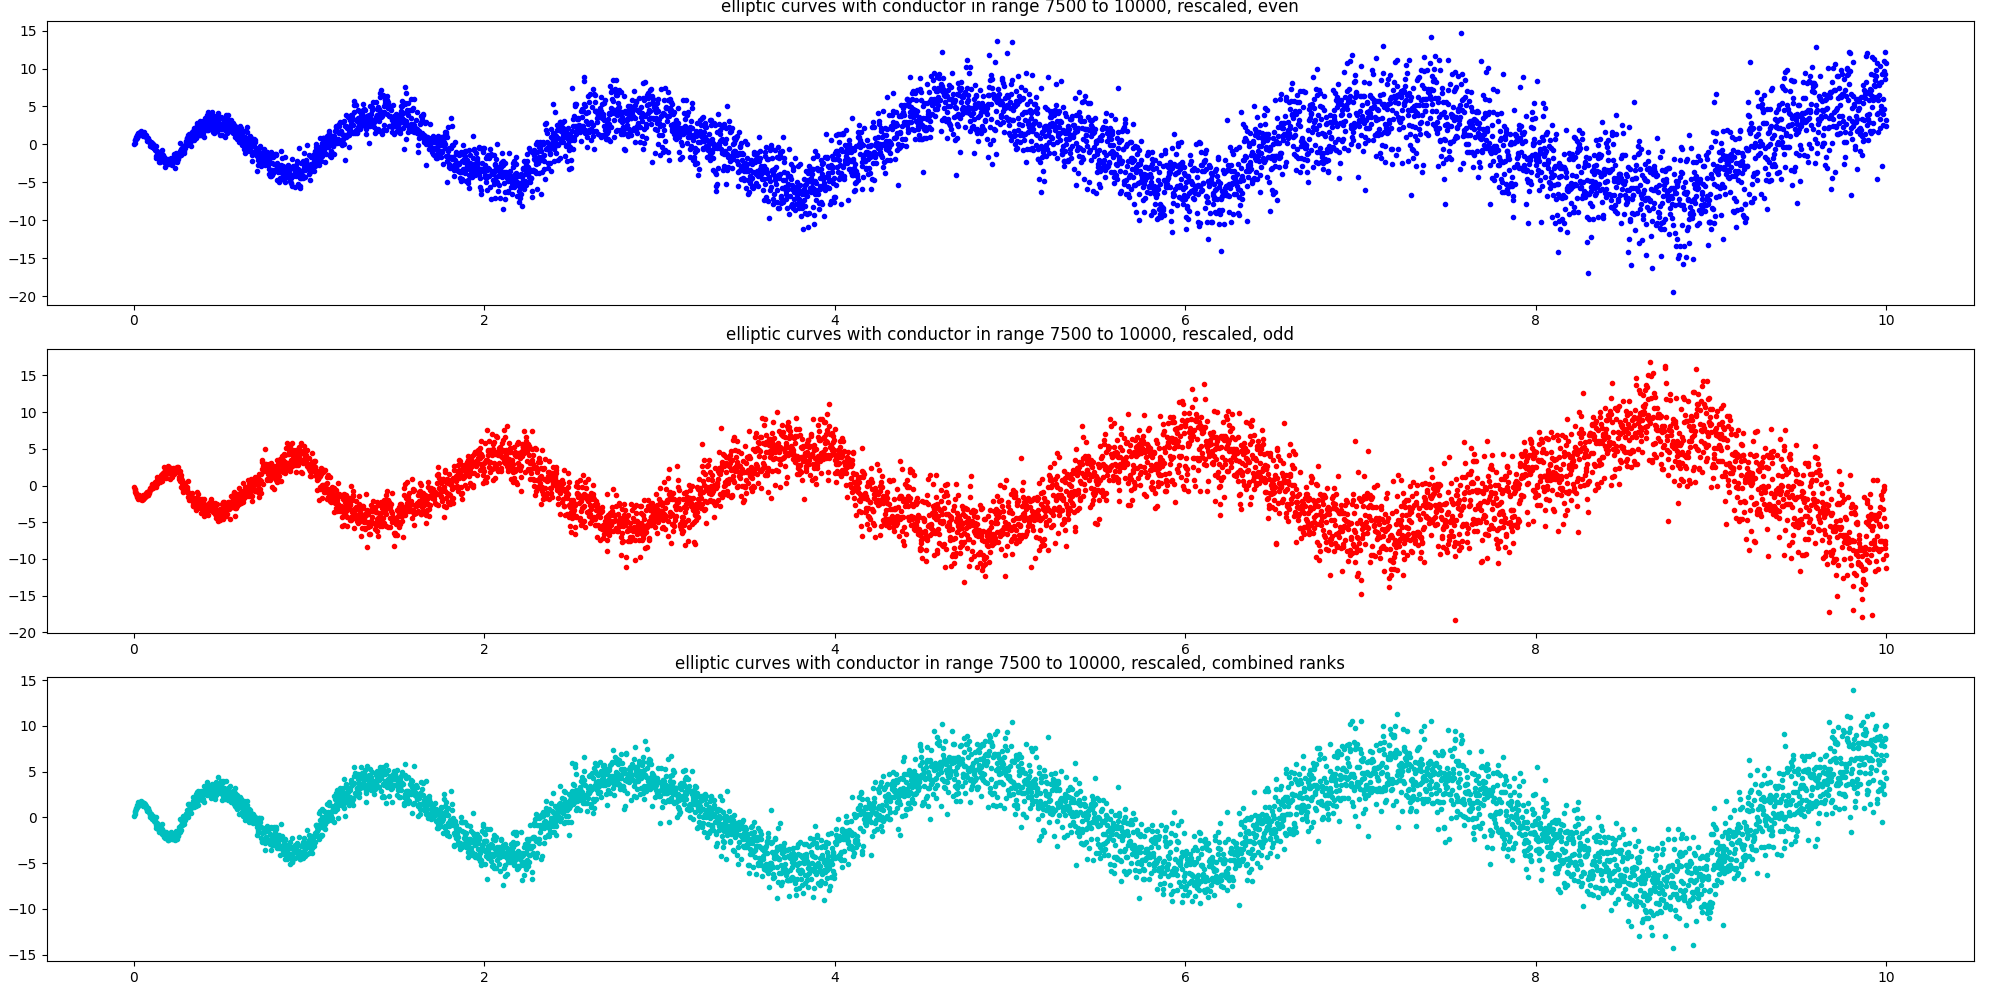

In [15]:
primes = ec.columns[2:];
ec_odd = ec[ec['rank']%2==1];
ec_even = ec[ec['rank']%2==0];
N,n = 10,5000;
x = np.linspace(1.0/n,N,n)
sum_aps_even,counts_even = bin_murmuration(ec_even,primes,x);
sum_aps_odd,counts_odd = bin_murmuration(ec_odd,primes,x);
fig6, ax6 = subplots(3,figsize=(20,10));
fig6.tight_layout()
for axis in ax6:
  ylim = (-10,10);
  xlim = (0,N);
  display_rescaled_murmuration(x,sum_aps_even,counts_even,sum_aps_odd,counts_odd,
                               "elliptic curves with conductor in range 7500 to 10000, rescaled",ax6)
## fig6.savefig("media/conductor_10000_rescaled_vs_not.png")

Above, we see some features not present in the original murmuration plot.
We will apply our ```bin_murmuration``` function to the curves with $1\leq N(E)\leq 50000$ in the notebook [cond_50k_rescaled](cond_50k_rescaled.ipynb), and we will see the features more prominently then.
We also notice that if the scale on the x-axis does not match up with any possible periodicity.
Let's try to bin the $a_p$'s according to $\sqrt{p/N(E)}$ instead of $p/N(E)$.

<ipython-input-4-e004facd1702>:35: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(x,sum_aps_even/counts_even,'b.');
<ipython-input-4-e004facd1702>:36: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(x,sum_aps_odd/counts_odd,'r.');
<ipython-input-4-e004facd1702>:37: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(x,(sum_aps_even-sum_aps_odd)/(counts_even+counts_odd),'c.');


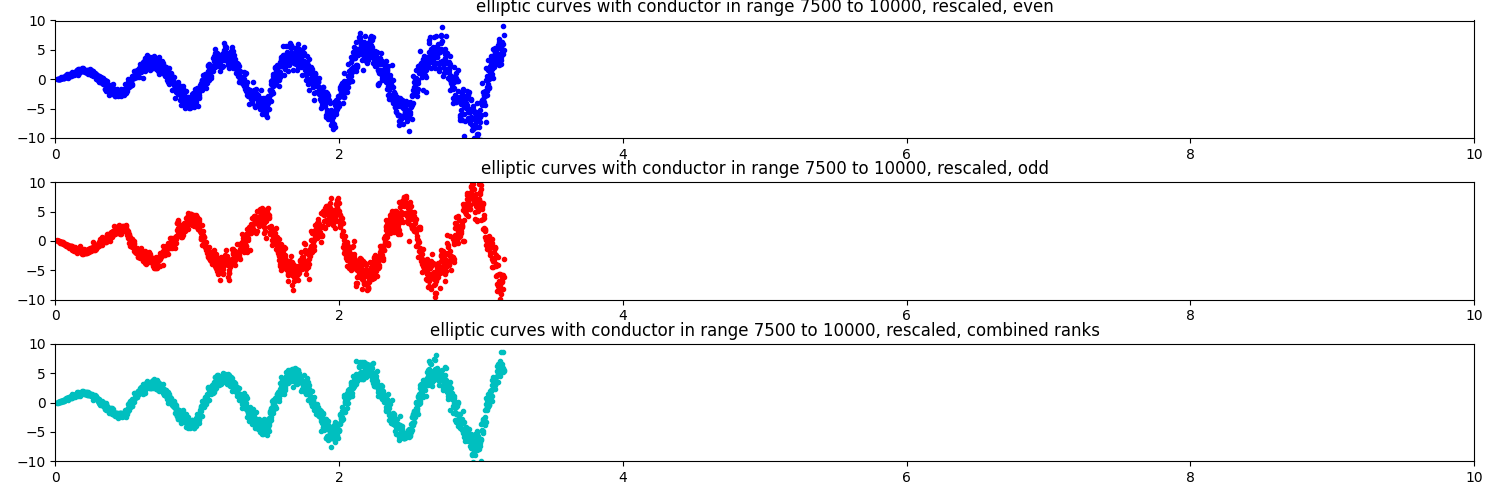

In [16]:
x_sq = x**2;
x_sq = x_sq[x_sq<=10]
sum_aps_even,counts_even = bin_murmuration(ec_even,primes,x_sq);
sum_aps_odd,counts_odd = bin_murmuration(ec_odd,primes,x_sq);
fig6, ax6 = subplots(3,figsize=(15,5));
fig6.tight_layout()
ylim = (-10,10)
xlim = (0,10)
display_rescaled_murmuration(np.sqrt(x_sq),sum_aps_even,counts_even,sum_aps_odd,counts_odd,
                             "elliptic curves with conductor in range 7500 to 10000, rescaled",ax6,xlim,ylim)